In [9]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd

df = pd.read_csv("kc_house_data.csv")
# df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

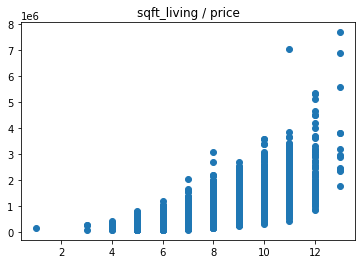

In [12]:
plt.scatter(df["grade"], df["price"])
plt.title("sqft_living / price")
plt.show()


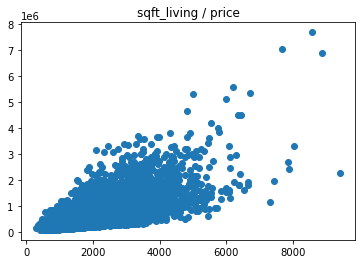

In [7]:
plt.scatter(df["sqft_above"], df["price"])
plt.title("sqft_living / price")
plt.show()


(<Figure size 432x288 with 1 Axes>, <Axes3DSubplot:>)

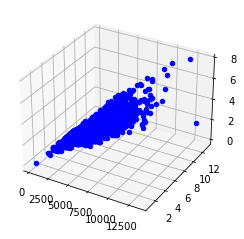

In [33]:
from skspatial.objects import Line
from skspatial.objects import Points
from skspatial.plotting import plot_3d


points = Points(
    [
        [0, 0, 0],
        [1, 1, 0],
        [2, 3, 2],
        [3, 2, 3],
        [4, 5, 4],
        [6, 5, 5],
        [6, 6, 5],
        [7, 6, 7],
    ],
)

points1 = []
for i in range(len(df["sqft_living"])):
    points1.append([df["sqft_living"][i], df["grade"][i],df["price"][i]])

points1 = Points(points1)

# print(points1)

line_fit = Line.best_fit(points1)


plot_3d(
    line_fit.plotter(t_1=-7, t_2=7, c='k'),
    points1.plotter(c='b', depthshade=False),
)